# Genome Visualization data organizer + plots

#### This file has the goal to help users rearange Sars-Cov-2 Genomic Data preprocessed by NextStrain and return it in a CSV format that can be easily read by common data vizualization software. For geographical data we suggest Kepler.gl, for other plots we suggest using excel or plotly chart studio. This notebook has been tested in a small dataset. It is not guaranteed to work in every scenario. To Run this notebook press the run button or press Shift+Enter to run each cell. 

### for this example we downloaded data from:
https://www.ncbi.nlm.nih.gov/labs/virus/vssi/#/virus?SeqType_s=Nucleotide&VirusLineage_ss=Severe%20acute%20respiratory%20syndrome%20coronavirus%202%20(SARS-CoV-2),%20taxid:2697049&CollectionDate_dr=1950-01-01T00:00:00Z%20TO%20NOW&CreateDate_dt=1950-01-01T00:00:00Z%20TO%20NOW
### then we preprocessed this genomes with next strain next clade
https://clades.nextstrain.org/results
### last we downloaded the results as a CSV

### Imports (packages that we will be using in our example)

In [1]:
import scipy.stats as stats
import geopandas
import pandas as pd
import numpy as np
import numba as nb
import plotly.express as px
from ipywidgets import interact, interact_manual, interactive,interactive_output, Layout
import plotly.graph_objects as go
import ipywidgets as widgets
import re
import umap
from sklearn.metrics import pairwise_distances
from sklearn.model_selection import cross_val_score,train_test_split, GridSearchCV
import lightgbm as lgb
from sklearn import preprocessing
from lightgbm import LGBMClassifier, LGBMRegressor
from sklearn.metrics import accuracy_score, classification_report
import shap
from scipy.sparse.csgraph import minimum_spanning_tree
from sklearn.neighbors import kneighbors_graph
from scipy.sparse import coo_matrix
import hdbscan
from datashader.bundling import hammer_bundle
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
from sklearn.model_selection import cross_validate
from IPython.core.display import display, HTML
import datetime
import dash_bio as dashbio
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))[['name', 'geometry']]
#display(HTML("<style>.container { width:100% !important; }</style>"))


### see https://docs.nextstrain.org/projects/nextclade/en/latest/user/algorithm/05-phylogenetic-placement.html for equation
@nb.njit()
def nextstrain_metric(ref,query):
    return ref.sum() + query.sum() - (ref == query).sum() - len(ref)

layout = widgets.Layout(width='75%')

def string2dict2(s, sep = ',', intro = ''):
    r = {}
    try:
        for i in s.split(sep):
            r[intro+i] = 1
    except: return r
    return r

def getpos(location):
    try: 
        return [float(country_loc[location].y), float(country_loc[location].x)]
    except:
        return [0.0,0.0]

gene_anotations = pd.DataFrame({
 'seqid': {0: 'NC_045512.2',  1: 'NC_045512.2',  2: 'NC_045512.2',  3: 'NC_045512.2',  4: 'NC_045512.2',  5: 'NC_045512.2',  6: 'NC_045512.2',  7: 'NC_045512.2',  8: 'NC_045512.2',
  9: 'NC_045512.2',  10: 'NC_045512.2', 11:'NC_045512.2' },
 'source': {0: 'RefSeq',  1: 'RefSeq',  2: 'RefSeq',  3: 'RefSeq',  4: 'RefSeq',  5: 'RefSeq',  6: 'RefSeq',  7: 'RefSeq',  8: 'RefSeq',  9: 'RefSeq',  10: 'RefSeq', 11: 'RefSeq'},
 'type': {0: 'CDS',  1: 'CDS',  2: 'CDS',  3: 'CDS',  4: 'CDS',  5: 'CDS',  6: 'CDS',  7: 'CDS',  8: 'CDS',  9: 'CDS',  10: 'CDS', 11: 'CDS'},
 'start': {0: 266,  1: 21563,  2: 25393,  3: 26245,  4: 26523,  5: 27202,  6: 27394,  7: 27756,  8: 27894,  9: 28274,  10: 29558, 11: 13468}, 
 'end': {0: 13468,  1: 25384,  2: 26220,  3: 26472,  4: 27191,  5: 27387,  6: 27759,  7: 27887,  8: 28259,  9: 29533,  10: 29674, 11: 21555},
 'ID': {0: 'cds-YP_009724389.1',  1: 'cds-YP_009724390.1',  2: 'cds-YP_009724391.1',  3: 'cds-YP_009724392.1',  4: 'cds-YP_009724393.1',  5: 'cds-YP_009724394.1',
        6: 'cds-YP_009724395.1',  7: 'cds-YP_009725318.1',  8: 'cds-YP_009724396.1',  9: 'cds-YP_009724397.2',  10: 'cds-YP_009725255.1', 11:'cds-YP_009724389.1'},
 'gene': {0: 'ORF1a',  1: 'S',  2: 'ORF3a',  3: 'E',  4: 'M',  5: 'ORF6',  6: 'ORF7a',  7: 'ORF7b',  8: 'ORF8',  9: 'N',  10: 'ORF10', 11: 'ORF1b'}}).sort_values('start').reset_index().drop('index', axis = 1)


### Open data from Nextstrain
The first step is open the CSV file that we downloaded from next strain. After opening we keep only the data which has good overall status for quality control

In [2]:
### this line opens the file nextcladeAsia.csv, to run your own data change this name and remember to first add the dataset to the folder of this notebook
genome_table = pd.read_csv('nextcladeAsia.csv', sep = ';')
## remove low quality sequences
genome_table = genome_table[genome_table["qc.overallStatus"] == "good"]


### Flatten the CSV file
 In the nextstrain csv output, some columns (substitutions, deletions, insertion, aa Substitution and aaDeletions) contain a list of variants. To better analyze the data we need to reshape those columns so each sample (one row) can be described as presence or absence of variants.

In [3]:
## these lines will process the columns which contain lists and expand them
genome_table_spread = pd.concat([
                 genome_table.drop(['seqName', 'substitutions', 'deletions', 'insertions', 'aaSubstitutions', 'aaDeletions'],axis = 'columns'),
                 genome_table['seqName'].str.split(r'\||/',expand=True).add_prefix('label_'), 
                 genome_table['substitutions'].apply(lambda x: pd.Series(string2dict2(x,  intro = 'nc_substitutions_'),dtype = int)).fillna(0).astype(int), 
                 genome_table['deletions'].apply(lambda x: pd.Series(string2dict2(x, intro = 'nc_deletions_') ,dtype = int)).fillna(0).astype(int), 
                 genome_table['insertions'].apply(lambda x: pd.Series(string2dict2(x,  intro = 'nc_insertions_'),dtype = int)).fillna(0).astype(int), 
                 genome_table['aaSubstitutions'].apply(lambda x: pd.Series(string2dict2(x,  intro = 'aa_Substitutions_'),dtype = int)).fillna(0).astype(int), 
                 genome_table['aaDeletions'].apply(lambda x: pd.Series(string2dict2(x,  intro = 'aa_Deletions_'),dtype = int)).fillna(0).astype(int), 
                 ],axis = 'columns')
genome_table_spread = genome_table_spread.dropna(axis =1)

In [4]:
### Lets take a look at the first Sars-CoV-2 see that the sample comes from China from December 2019 from label_3 and label_5
genome_table_spread.iloc[0, 30:50]

qc.frameShifts.totalFrameShifts               0
qc.frameShifts.score                        0.0
qc.frameShifts.status                      good
qc.stopCodons.totalStopCodons                 0
qc.stopCodons.score                         0.0
qc.stopCodons.status                       good
label_0                            NC_045512.2 
label_1                                        
label_2                                       B
label_3                                   China
label_4                                   China
label_5                                 2019-12
nc_substitutions_C241T                        0
nc_substitutions_C313T                        0
nc_substitutions_C3037T                       0
nc_substitutions_C6318T                       0
nc_substitutions_C14408T                      0
nc_substitutions_A23403G                      0
nc_substitutions_G28881A                      0
nc_substitutions_G28882A                      0
Name: 0, dtype: object

## geocoding
geocoding is converting an adress to a Latitude and Longitude format. Most geographical plotting software uses the Lat/lon format, so the following lines will do the geocoding using the open street map api

In [5]:
### here we are just renaming the label_3 column as the country of origin. the number of the label might change based on how many metadata columns there are.
### if using your own data check which column has the country of origin and change it here VVVVVV
genome_table_spread['Country'] =                                      genome_table_spread['label_3'].apply(lambda x : x)

### this lines does the geocoding for all unique locations (this might take a while! it might timeout if connection is unstable)
%time country_loc = {country: geopandas.tools.geocode(country, provider='nominatim', user_agent='autogis_xx', timeout=4).geometry for country in genome_table_spread.Country.unique()}

Wall time: 3min 1s


In [6]:
### this line adds the Lat|Lon to the dataframe if geocoding failed it returns 0,0 as lat|lon
genome_table_spread[['Latitude', 'Longitude']] = genome_table_spread.apply(lambda x: getpos(x.Country),   result_type='expand', axis = 1)

### if plottling the data as a scatterplot adding a little variation to the Lat|Lon values will help to visualize points that would overlap otherwise 

In [7]:
genome_table_spread[['lat_jitter', 'long_jitter']] = genome_table_spread.apply(lambda x: [[x.Latitude + np.cos(y)*z, x.Longitude + np.sin(y)*z] \
                                                          for y,z in [(np.random.uniform(0, 2*np.pi), np.random.random())]][0], result_type='expand', axis = 1)

## fixing datetime columns
#### Here we will rearange the datetime format from our dataset. This will also standardize dates for which the day value is missing

In [26]:
## this line reads the dates and makes a standard datetime format
genome_table_spread['data_continuous'] = genome_table_spread['label_5'].apply(pd.to_datetime)

## this line reads the dates and transforms it into something readable for kepler.gl
genome_table_spread['date_kepler'] = genome_table_spread.data_continuous.dt.strftime('%m/%d/%Y %H:%M:%S')

## if prefered we can count in days since the first case in the dataset 
genome_table_spread['days_after_start'] = (genome_table_spread.data_continuous - genome_table_spread.data_continuous.min() ).dt.days

## if prefered we can count in months since the first case in the dataset 
genome_table_spread['mo_after_start'] = genome_table_spread['days_after_start']//30

## we can also make the continuous date variable into categories, in this case separating into early medium late cases
genome_table_spread['data_discrete'] = pd.cut(genome_table_spread['days_after_start'], 5, labels=["early","early-medium" ,"medium",'medium-late' ,"late"])


In [25]:
5//3

1

# At this point we can already download the data for analysis in excel or Kepler.
### Below we can show some analysis and plotting examples that can be of interest but may be easier and more precise to replicate in other software

In [9]:
### download the data
genome_table_spread.to_csv('output_LatLon_datetime.csv')

### Here we can take a look in the mumber of Substitutions over time and per clade

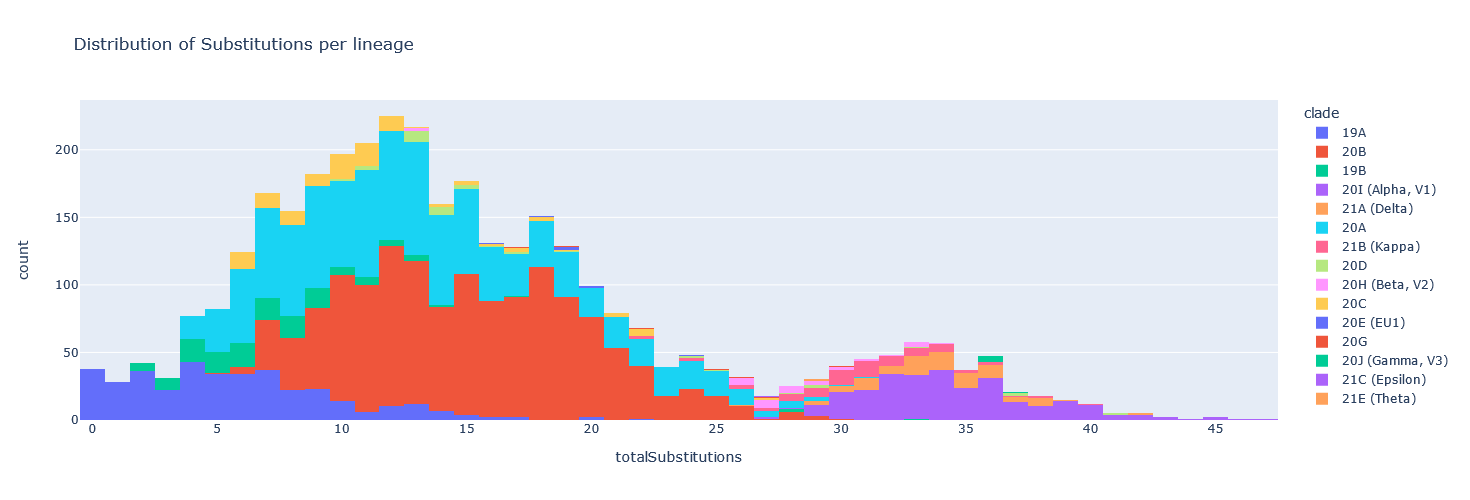

In [10]:
fig = px.histogram(genome_table_spread, x="totalSubstitutions", color="clade", nbins = 80, title = 'Distribution of Substitutions per lineage')
fig.update_layout(
    autosize=False,
    width=1500,
    height=500,)
display(fig)

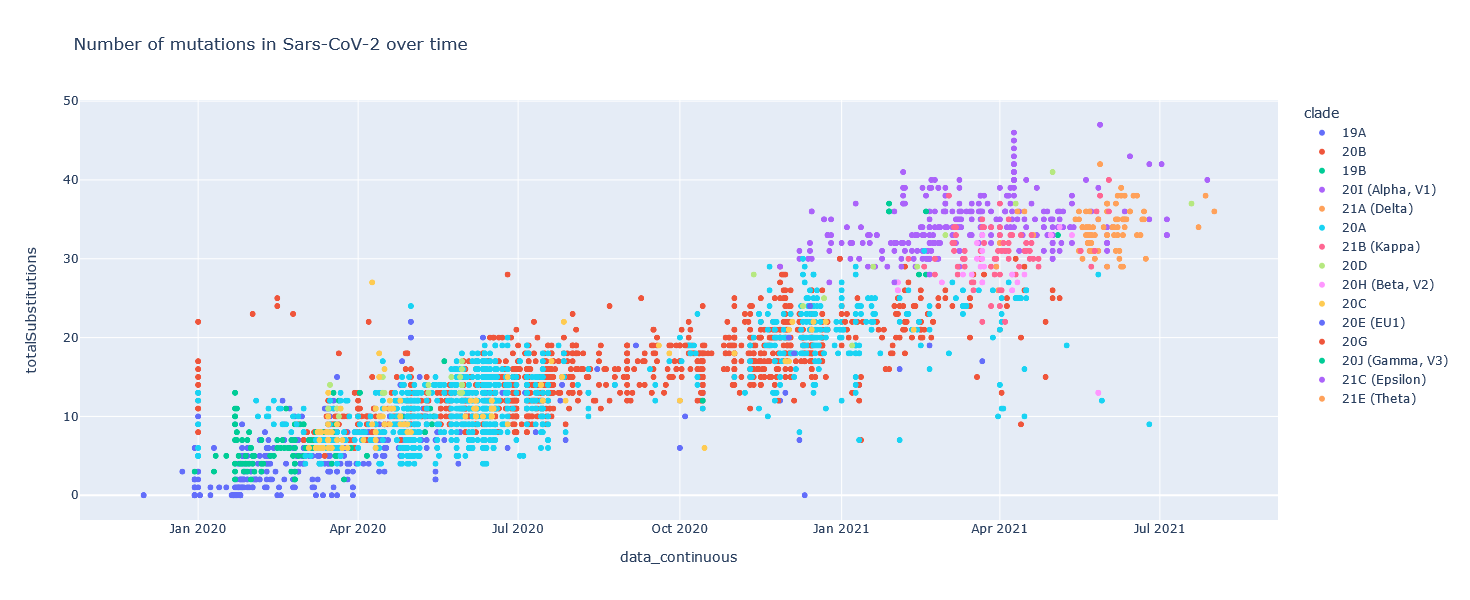

In [11]:
### here we can see that the number of mutations increase over time.
fig = px.scatter(genome_table_spread, y="totalSubstitutions",x="data_continuous",color="clade", title = 'Number of mutations in Sars-CoV-2 over time')
fig.update_layout(
    autosize=False,
    width=1400,
    height=600,)
display(fig)

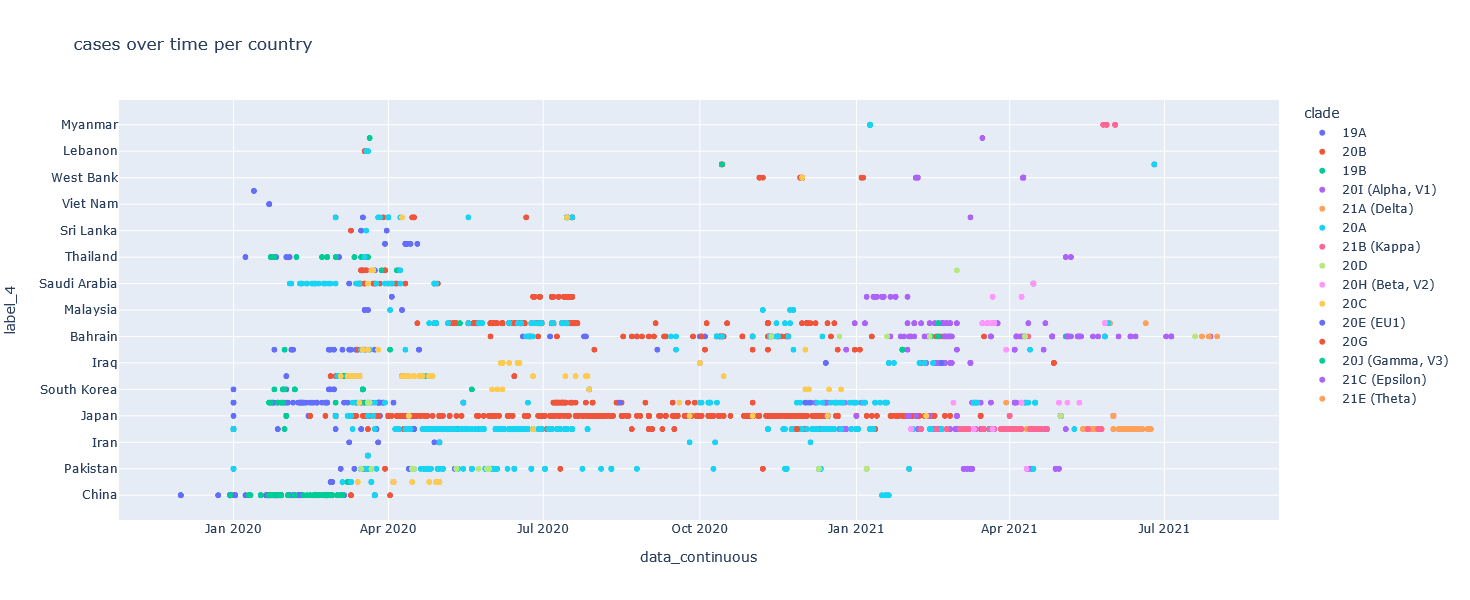

In [12]:
### here the country id is in label_4 we can change that accodingly depending on your dataset 
###                       change here     VVVVVV
fig = px.scatter(genome_table_spread, y="label_4",x="data_continuous",color="clade", title = 'cases over time per country')
fig.update_layout(
    autosize=False,
    width=1400,
    height=600,)
display(fig)

# let's check the countries with most sampling and the variants most common in this sampling

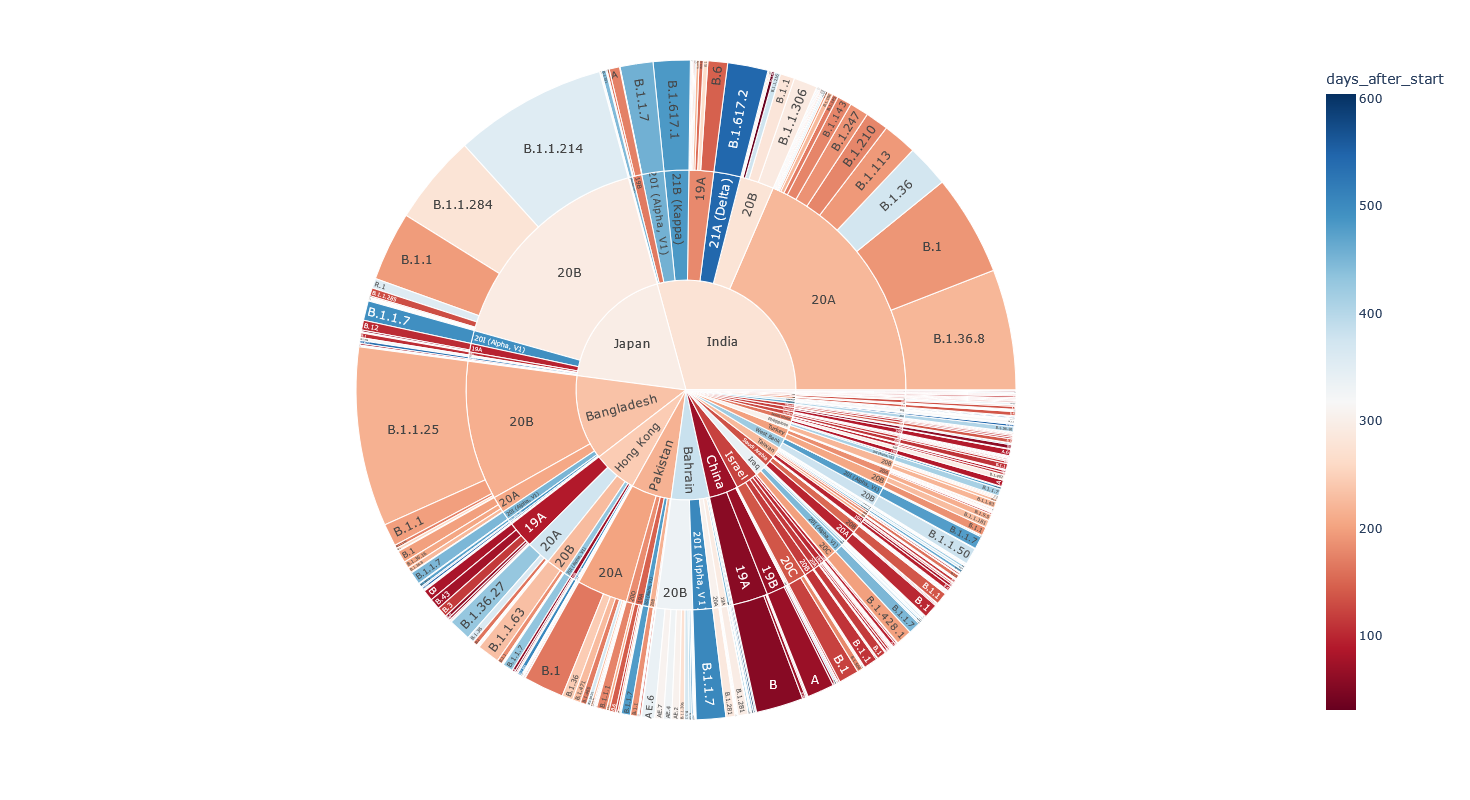

In [13]:
## here we can do a sunburst plot, which helps us visualize which countries have more samples and which are the most common lineages in each country
## to add more features, we can change the path VVVV list to include all columns of interest. Be careful of including only including columns that are categorical
fig = px.sunburst(genome_table_spread,          path=['label_4', 'clade', 'label_2'], color = 'days_after_start',   color_continuous_scale='RdBu')
fig.update_layout(
    autosize=False,
    width=800,
    height=800,)
display(fig)

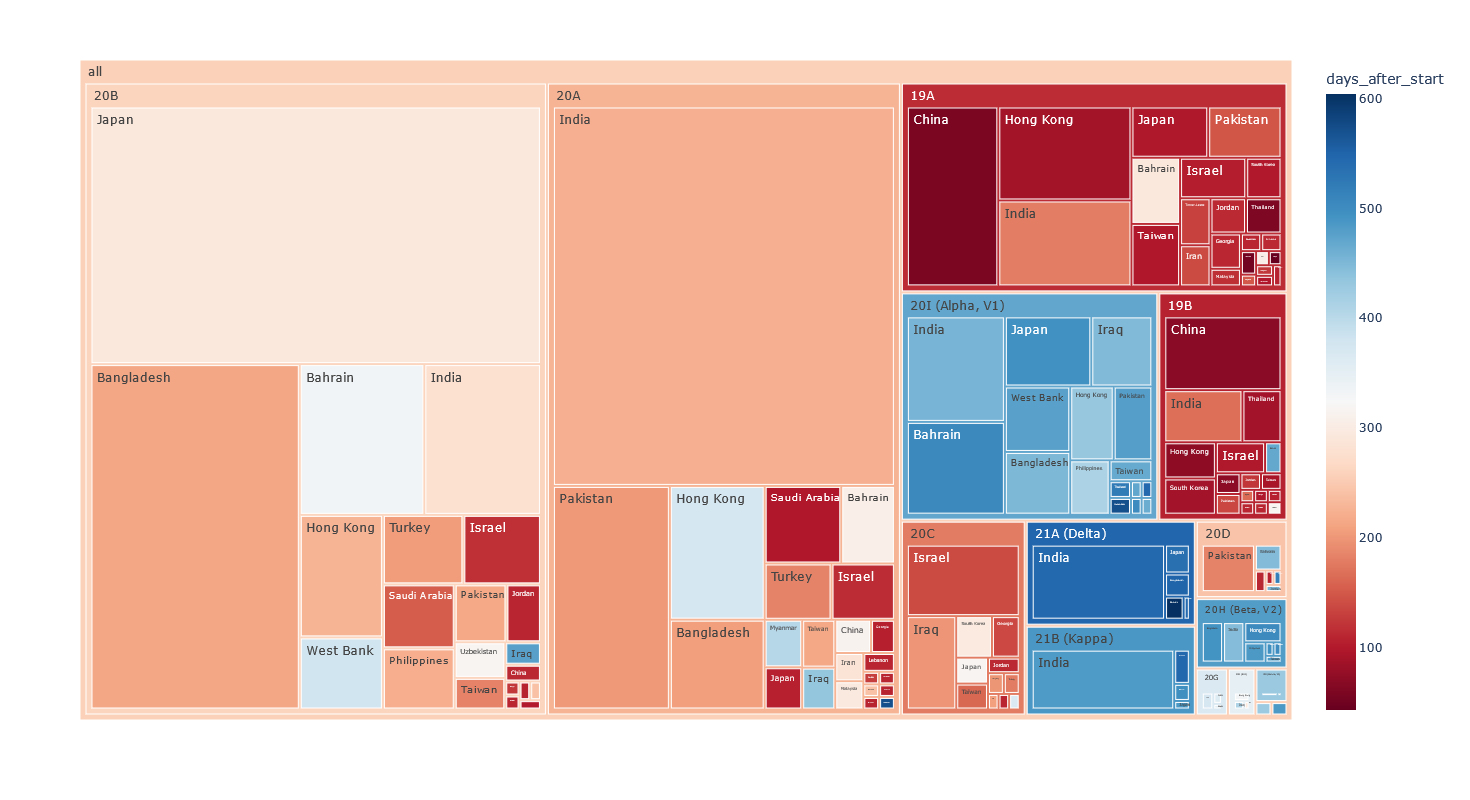

In [14]:
fig = px.treemap(genome_table_spread, path=[px.Constant("all"),  'clade','label_4'], color = 'days_after_start', color_continuous_scale='RdBu') #'label_2'
fig.update_layout(
    autosize=False,
    width=1200,
    height=800,)
display(fig)

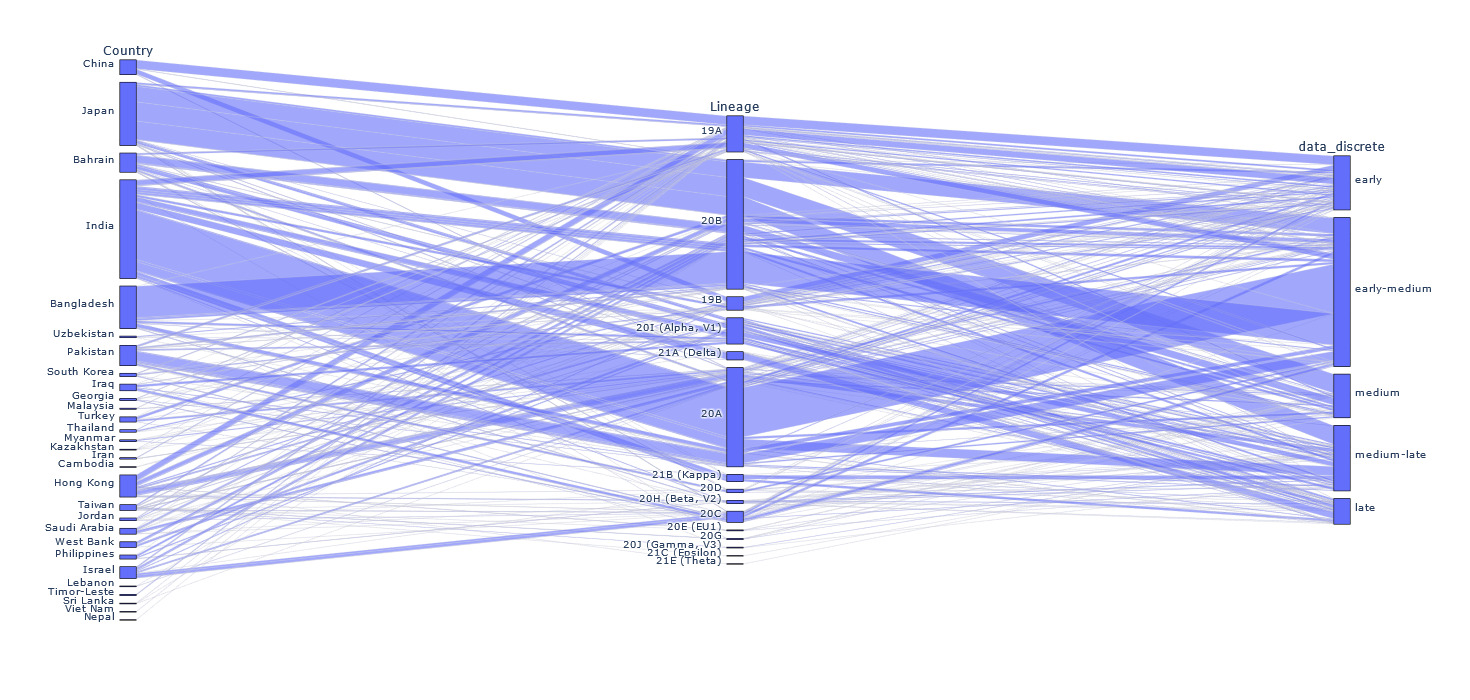

In [15]:
## here is another was of visualizing the same data from the graph above. Here we conect 
fig = px.parallel_categories(genome_table_spread,  dimensions=['label_4', 'clade','data_discrete'],
                             labels={"label_4": "Country","clade": "Lineage"}) #color = 'days_after_start',
fig.update_layout(
    autosize=False,
    width=1400,
    height=700,)
display(fig)


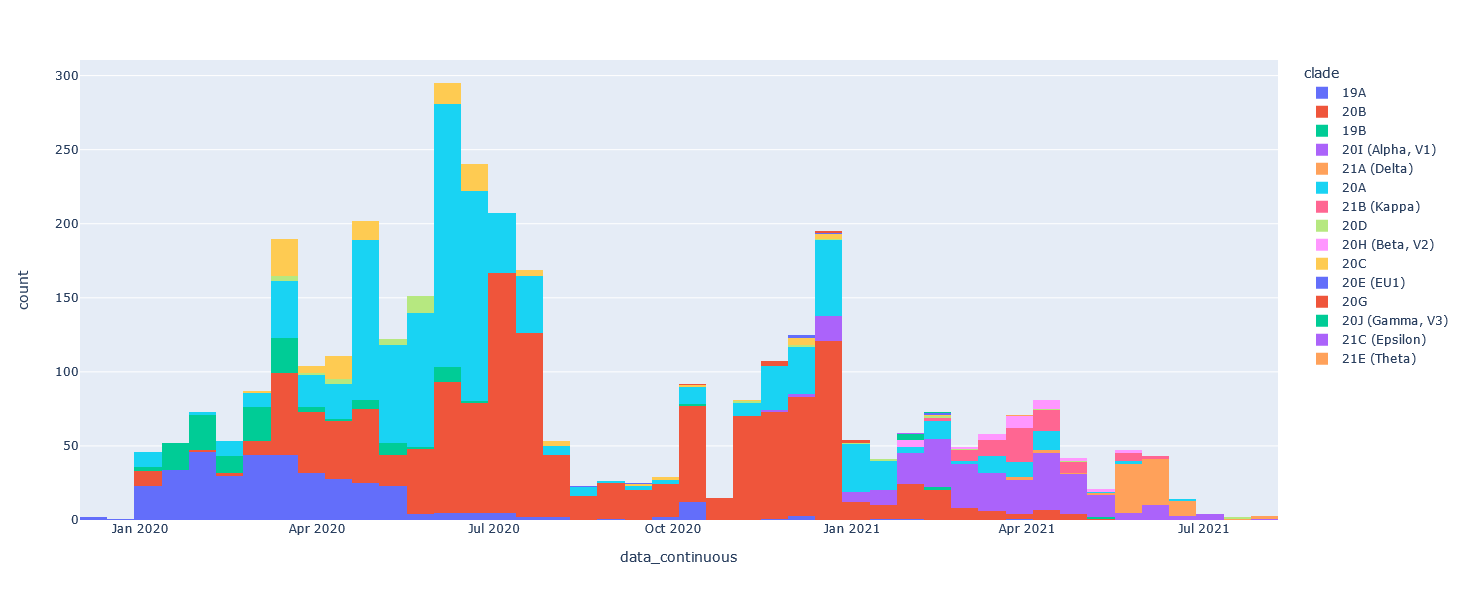

In [16]:
#here we can see a histogram of the number of samples over time and the frequencies of each lineage
fig = px.histogram(genome_table_spread, x="data_continuous", color="clade", nbins = 80).update_xaxes(categoryorder='total descending')
fig.update_layout(
    autosize=False,
    width=1500,
    height=600,)
display(fig)

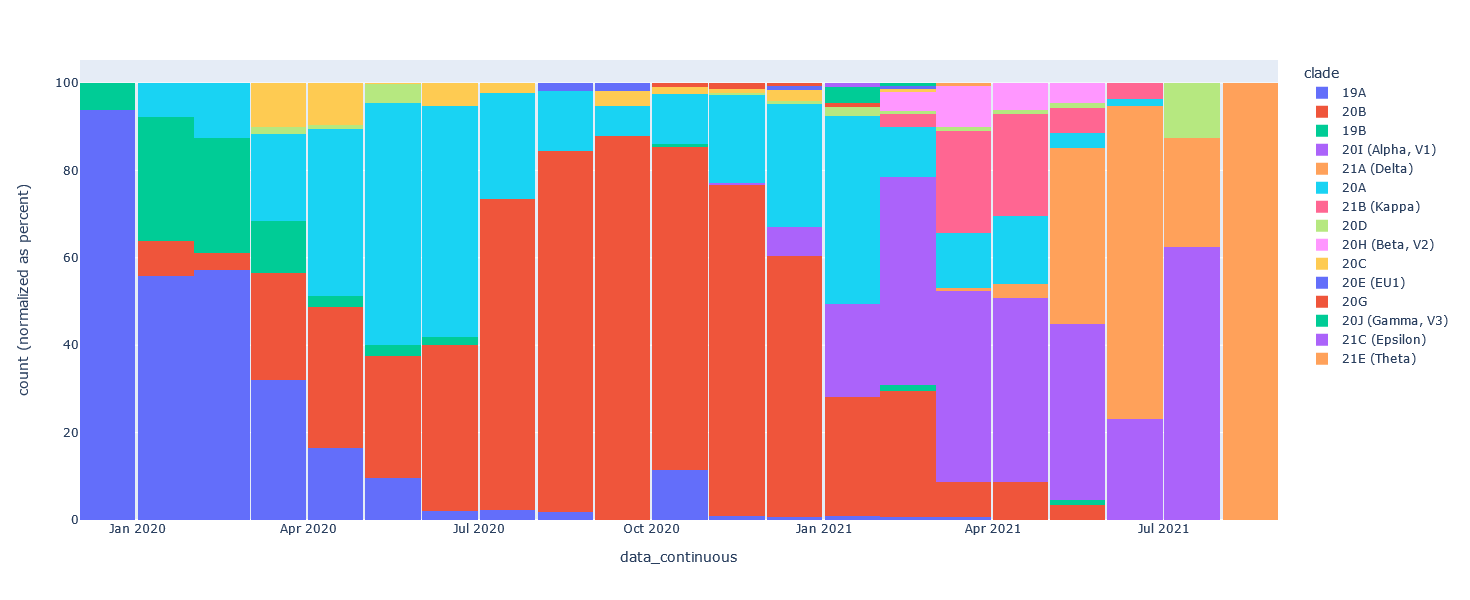

In [17]:
#here we have the same as above but, normalizing the each bar in the histogram to add to 100%
fig = px.histogram(genome_table_spread, x="data_continuous", color="clade", barnorm = 'percent', nbins = 40)
fig.update_layout(
    autosize=False,
    width=1400,
    height=600,)
display(fig)

### here we can visualize how often individual mutations gets fixated in the genome

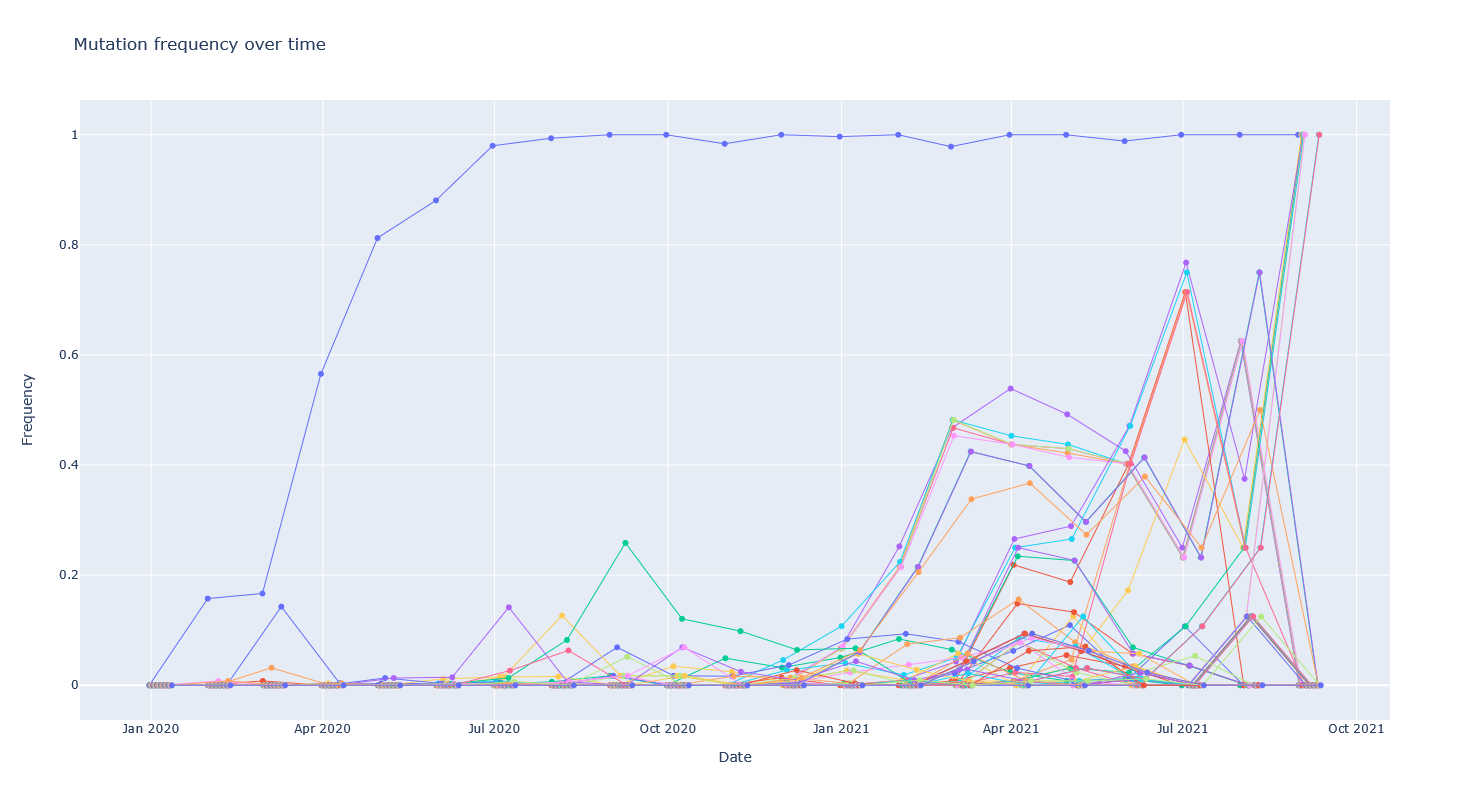

Wall time: 984 ms


In [18]:
%%time
resampled = genome_table_spread.set_index('data_continuous').resample('1M').mean().reset_index()
fig = go.Figure()
for num, i in enumerate([x for x in genome_table_spread.columns if 'aa_' in x and 'S:' in x and resampled[x].max()>.05]):
    fig.add_trace(go.Scatter(y=resampled[i], x = resampled.data_continuous.apply(lambda x: x+ num/50* datetime.timedelta(10))  , mode="lines+markers",
                             hovertext =i,line = {'width': 1})) #showlegend=False
fig.update_layout( autosize=False,width=1300,height=800, showlegend=False, title = 'Mutation frequency over time', xaxis = {'title':"Date"}, yaxis = {'title':"Frequency"}) 
#fig.update_xaxes(rangeslider_visible=True)
fig.show()


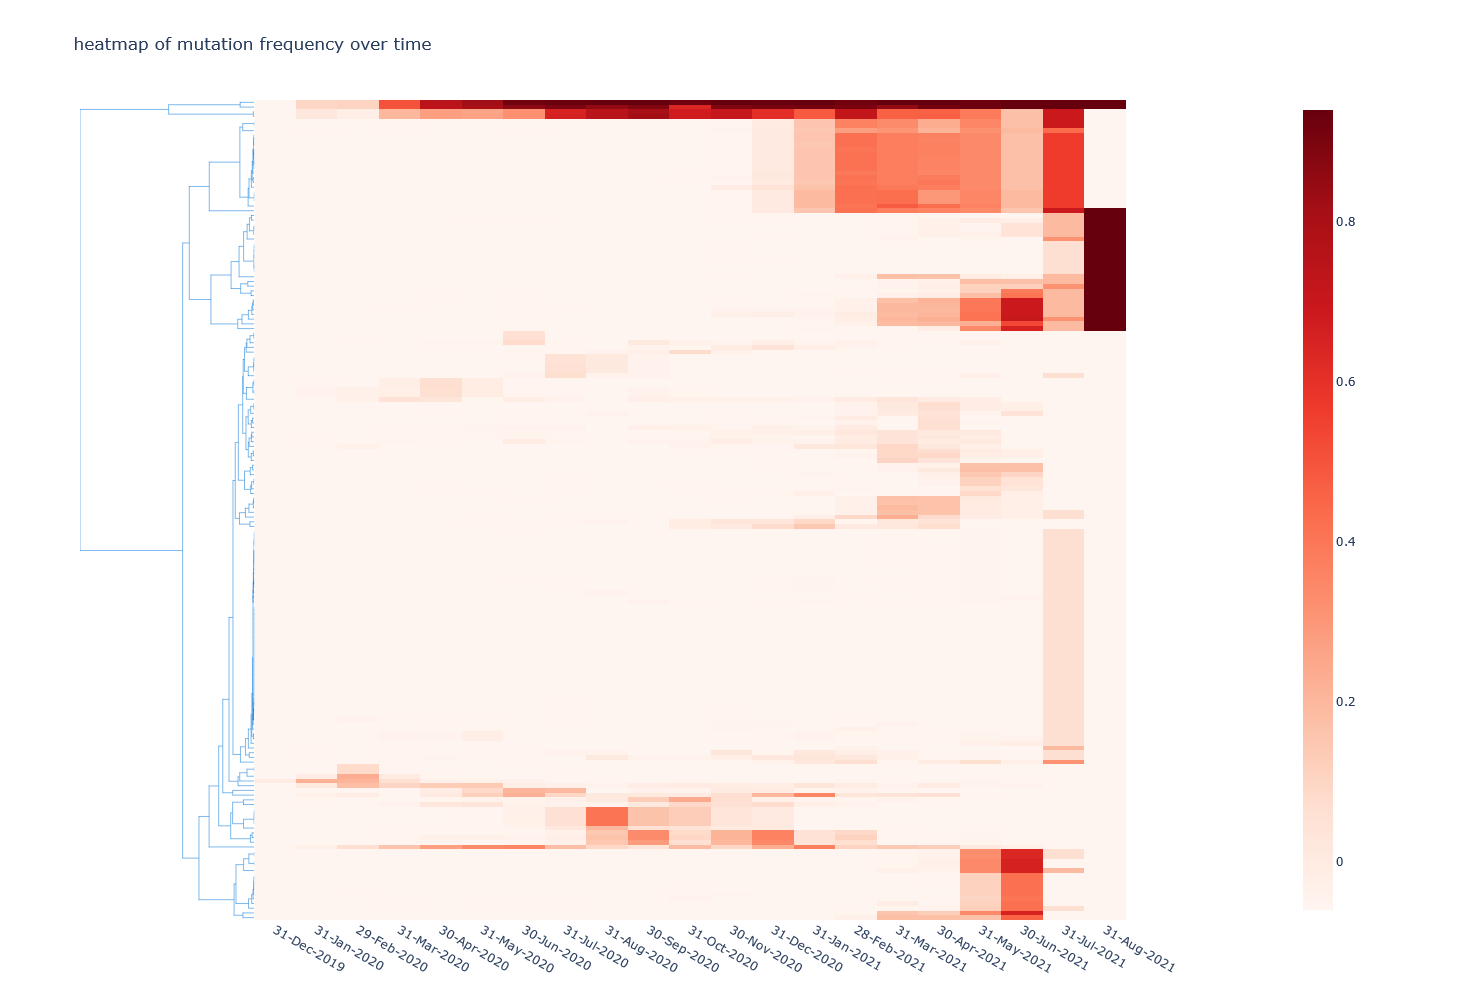

In [19]:
resampled = genome_table_spread.set_index('data_continuous').resample('1M').mean().reset_index()
cols_interest = [x for x in genome_table_spread.columns if 'aa_' in x ]#and 'S:' in x
resampledT = resampled[cols_interest].T
resampledT = resampledT[resampledT.max(axis = 1)> .1]
fig =dashbio.Clustergram(
                data=resampledT.values,
                row_labels=list(resampledT.index),hidden_labels='row',
                column_labels=resampled.data_continuous.dt.strftime('%d-%b-%Y').tolist(), color_map='Reds',
                cluster = 'row')
fig.update_layout( autosize=False,width=1300,height=1000, title = 'heatmap of mutation frequency over time')

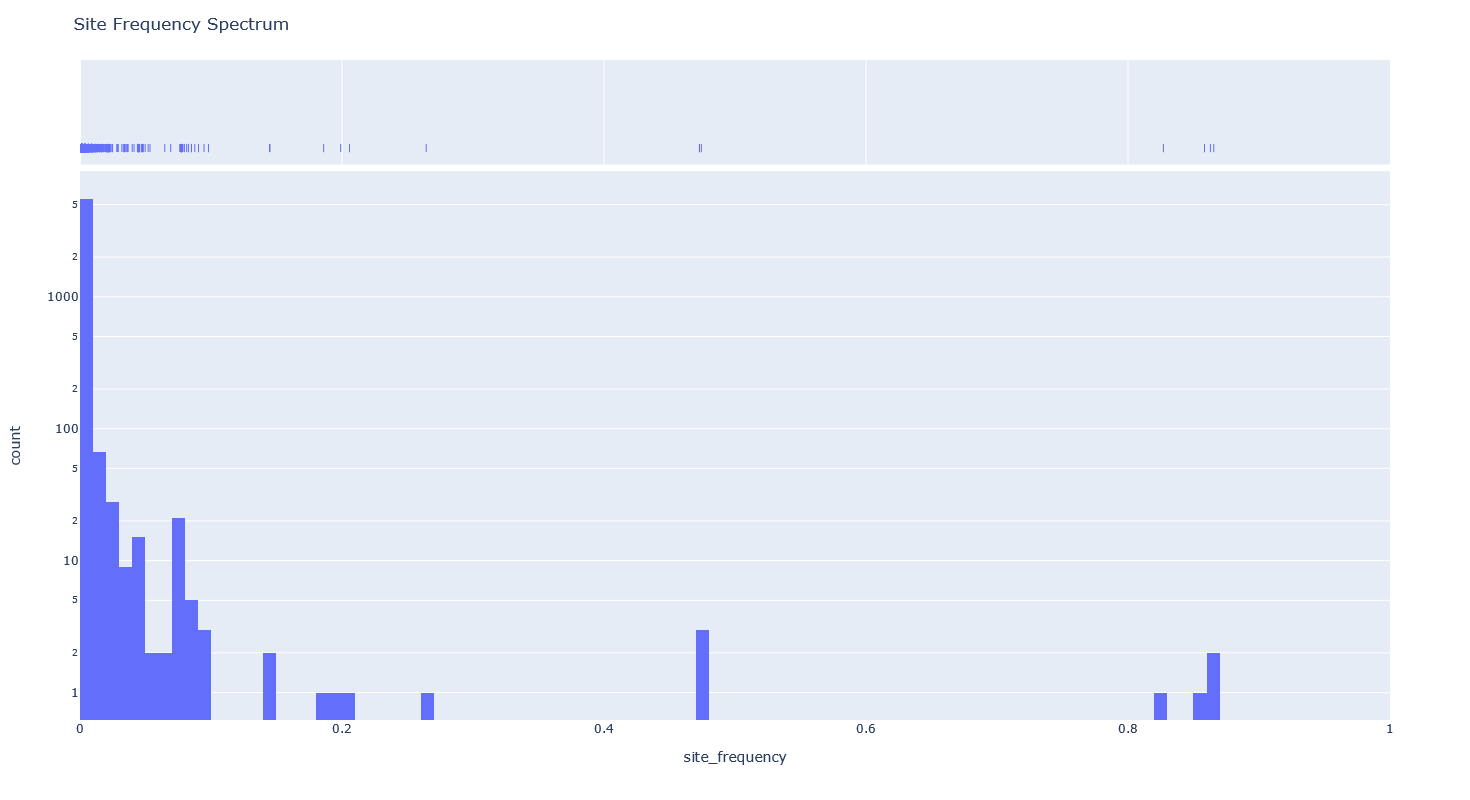

In [20]:
df_mean = pd.DataFrame(genome_table_spread[[x for x in genome_table_spread.columns if 'nc_' in x]].mean(axis =0), columns = ['site_frequency'])
fig = px.histogram(  df_mean, marginal="rug", log_y = True, x="site_frequency" ,nbins = 120)
fig.update_xaxes(range=[0,1])
fig.update_layout( autosize=False,width=1300,height=800,title = 'Site Frequency Spectrum')

### dimesionality reduction using UMAP:
##### Dimesionality reduction is a form representing the genomic all mutations in 2 dimensions. Clusters of samples means that the samples in the cluster are genetically similar and the size of the cluster is a form of observing diversity within a group
##### This methodology is different from phylogenetic trees and have a different purpose too. See https://www.nature.com/articles/nbt.4314 and https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3989108/. the second paper talks about PCA, which is a different dimensionality reduction algorithm
##### The function below allows the user to cluster our sampes based on the type of mutation (nucleotide vs aminoacid) and allows us to remove rare mutations with the minor allele frequency (maf)



In [ ]:
@interact_manual(
                 maf = widgets.FloatSlider(value=0.01, min=0, max=.5, step=0.01, continuous_update=False, orientation='horizontal', 
                          readout=True, readout_format='.2f', description = 'Choose maf',layout = layout),
                 typ = widgets.RadioButtons(options=  ['nucleotide', 'aminoacid'], value = 'nucleotide', description = 'Choose type of mutation', layout={'width': 'max-content'}),
                 n_neighbors = widgets.IntSlider(value=50, min=15, max=150, step=1, continuous_update=False, orientation='horizontal', description = 'n neighbors',layout = layout),
                 )
def Generate_umap(maf, typ, n_neighbors):
    convert = {'nucleotide': 'nc_substitutions', 'aminoacid':'aa_'}
    nc_mutation_list = [x for x in genome_table_spread.columns if convert[typ] in x and genome_table_spread[x].sum() > genome_table_spread[x].shape[0]*maf]
    
    #y = preprocessing.LabelEncoder().fit_transform(genome_table_spread.clade)
    
    umap_embeding = umap.UMAP(n_neighbors= n_neighbors,metric = 'manhattan', densmap = True).fit(genome_table_spread[nc_mutation_list])#, y)#, , densmap = True
        
    genome_table_spread[['UMAP1_nucleotide', 'UMAP2_nucleotide']] = umap_embeding.transform(genome_table_spread[nc_mutation_list])
    
    fig = px.scatter(genome_table_spread, x="UMAP1_nucleotide", y="UMAP2_nucleotide", color="clade", size='totalSubstitutions', hover_data = ['Country', 'data_continuous'])
    fig.update_layout(
        autosize=False,
        width=1000,
        height=1000,)
    display(fig)

# Connect closest sequences

In [ ]:
### here we want to create a minimum spanning tree to connect similar samples based on their UMAP values
edges = kneighbors_graph(genome_table_spread[['UMAP1_nucleotide','UMAP2_nucleotide']], 200, mode = 'distance', include_self= False, n_jobs = -1)
mst_graph = coo_matrix(minimum_spanning_tree(edges))

In [ ]:
### here we get all the edges from the minimum spanning tree and add to them information about the in and out nodes
features_of_interest = ['label_2', 'label_3', 'label_5','Latitude', 'Longitude', 'data_continuous', 'UMAP1_nucleotide', 'UMAP2_nucleotide']
%time mst_arrows = pd.DataFrame([genome_table_spread.iloc[i, np.isin(genome_table_spread.columns,features_of_interest)].tolist() \
                                 + genome_table_spread.iloc[j,np.isin(genome_table_spread.columns,features_of_interest)].tolist() \
                                 +[ 100*(1- (k/(k+1)))  ]  \
                                 for i,j, k in zip(mst_graph.col, mst_graph.row, mst_graph.data)], \
                                columns =['in_'+x for x in features_of_interest]+['out_'+x for x in features_of_interest] + ['genetic_similarity'])

In [ ]:
# here we save this edge data for vizualization in kepler.gl
mst_arrows.to_csv('arrowsAsia.csv')

## edge bundling with datashader
#### As the number of samples is quite large, using edge bundling allows us to group edges of our network to better visualize paths. As a warning the path can vary significantly depending on the strength of the bundling. Those parameters can be adjusted within the hammer_bundle function

In [ ]:
#reorganize data for datashader package
nodes_umap = genome_table_spread[['UMAP1_nucleotide','UMAP2_nucleotide']].reset_index().rename(columns={'index': 'name', 'UMAP1_nucleotide': 'x', 'UMAP2_nucleotide': 'y'})
edges_df = pd.DataFrame(zip(mst_graph.row, mst_graph.col, mst_graph.data), columns=['source', 'target', 'weight'])

#umap_bundle
bundled_points = hammer_bundle(nodes_umap, edges_df, decay= .4, initial_bandwidth = .4, tension = .1)
bundleddf =  pd.DataFrame(bundled_points).dropna()

#geographical_bundle 
nodes_spatial = genome_table_spread[['Latitude','Longitude']].reset_index().rename(columns={'index': 'name', 'Latitude': 'x', 'Longitude': 'y'})
bundled_points_spatial = hammer_bundle(nodes_spatial, edges_df, decay= .4, initial_bandwidth = .4, tension = .1)

# here we save the geographical bundle for visualization in kepler.gl
bundleddf_spatial = pd.DataFrame(bundled_points_spatial).dropna()#
bundleddf_spatial.to_csv('spatial_bundle.csv')

# visualize the genetic path between samples
fig = px.scatter(genome_table_spread, x="UMAP1_nucleotide", y="UMAP2_nucleotide", color="clade", size='totalSubstitutions', hover_data = ['Country', 'data_continuous'])
fig.add_trace(px.scatter(bundleddf, x="x", y="y").data[0])
fig.update_layout( autosize=False,width=1000,height=1000,)

display(fig)

In [ ]:
### save to the main dataframe the UMAP information
genome_table_spread.to_csv('output_LatLon_datetime.csv')

## now we can plot on the map

In [ ]:
#### now we can plot on the map 
fig = px.scatter_mapbox(genome_table_spread, lat="lat_jitter",  lon="long_jitter",  color="clade", size_max=15
                        , title= 'Possible Sars-Cov-2 routes')#size="totalSubstitutions",   animation_frame="date_kepler",
fig.add_trace(go.Scattermapbox(lon = bundleddf_spatial.y, lat = bundleddf_spatial.x,    
                               marker=go.scattermapbox.Marker(size=5, color='gray',opacity=0.3), name = 'edge bundling'))

fig.update_layout( autosize=False,width=1300,height=1000, mapbox = {'style':'carto-positron', 'zoom': 2}) 
fig.show()

In [ ]:
## example of choropleth of most common variant

most_common_variant = genome_table_spread.groupby(['label_4', 'days_after_start'],as_index=False)['clade'].agg(lambda x:x.value_counts().index[0])
most_common_variant = world.merge(most_common_variant, how ='inner', right_on= 'label_4', left_on = 'name' )

fig = px.choropleth_mapbox(most_common_variant,
                           geojson=most_common_variant.geometry,
                           locations=most_common_variant.index,
                           animation_frame="mo_after_start", 
                           color="clade")
fig.update_layout( autosize=False,width=1300,height=1000, mapbox = {'style':'carto-positron', 'zoom': 2}) 
fig.show()

## Find mutations associated with different groups (simplified GWAS)

In [144]:
##### here we can choose 2 groups to find if any of the variants is statistically significant between groups. 
#####In this example we are comparing samples Delta and kappa variants from India 
group1 = genome_table_spread.query('label_4 == "India" and clade == "21A (Delta)"')
group2 = genome_table_spread.query('label_4 == "India" and clade == "21B (Kappa)"')

#####This would be a comparison between samples from Israel and the West Bank for differences. 
#group1 = genome_table_spread.query('label_4 == "Israel"')
#group2 = genome_table_spread.query('label_4 == "West Bank"')

In [145]:
### this large function will do a t-test for every mutation present in the dataset and output the p-value between groups 1 and 2 above 
### the user can specify a minor allele frequency to only allow variants that are common

@interact_manual(maf = widgets.FloatSlider(value=.05, min=0.0, max=.5, step=0.01, continuous_update=False, orientation='horizontal', 
                          readout=True, readout_format='.2f', description = 'Choose maf', layout = layout),
                 typ = widgets.RadioButtons(options=  ['nucleotide', 'aminoacid'], value = 'nucleotide', description = 'Choose type of mutation', layout={'width': 'max-content'}))
def ttest_dataframe(maf, typ):
    convert = {'nucleotide': 'nc_', 'aminoacid':'aa_'}
    union = pd.concat([group1, group2])
    nc_mutation_list = [x for x in union.columns if convert[typ] in x and union[x].sum() > union[x].shape[0]*maf]
    output_pvals = {}

    for mutation in nc_mutation_list:
        pval = ttest_ind(group1[mutation].values, group2[mutation].values, equal_var = False)[1]
        if typ == 'nucleotide':output_pvals[mutation] = {'pval': pval if pval>1e-20 else 1e-20, 'pos': int(re.findall(r'\d+', mutation)[-1])}
        else:
            gene_pos = mutation.split(':')[0].split('_')[-1]
            try:
                gene_pos2 = gene_anotations.query("@gene_pos in gene").iloc[0]['start']
                output_pvals[mutation] = {'pval': pval if pval >1e-20 else 1e-20, 'pos': gene_pos2+  3*int(re.findall(r'\d+', mutation)[-1])}
            except: pass
    significance = pd.DataFrame(output_pvals).T.dropna().sort_values('pval')
    significance['-Log10(P-value)'] = -np.log10(significance.pval)
    fig = px.scatter(significance, x="pos", y="-Log10(P-value)", hover_data = [significance.index], title = 'Significant Variants between group 1 and group 2')

    for num,i in gene_anotations.iterrows():
        fig.add_trace(go.Scatter(y=[-1,-1], x = [i.start, i.end], mode="lines",
                                 hovertext =i.gene,text=i.gene, name=i.gene ,line = {'width': 10}))
    fig.add_trace(go.Scatter(y=[-np.log10(0.05/len(nc_mutation_list)),-np.log10(0.05/len(nc_mutation_list))], x = [0, 29900], mode="lines", 
                              line = dict(color='firebrick', width=3, dash='dot'), name = 'bonferroni significance'))
    fig.update_xaxes(range=[0,29674], rangeslider_visible=True)
    fig.update_layout(
        autosize=False,
        width=1400,
        height=800,)
    display(fig)

interactive(children=(FloatSlider(value=0.05, continuous_update=False, description='Choose maf', layout=Layout…

## Machine Learning example

In [ ]:

@interact_manual(
                 maf = widgets.FloatSlider(value=.05, min=0.0, max=.5, step=0.01, continuous_update=False, orientation='horizontal', 
                          readout=True, readout_format='.2f', description = 'Choose maf',
                         layout = layout),
                 typ = widgets.RadioButtons(options=  ['nucleotide', 'aminoacid'], value = 'nucleotide', description = 'Choose type of mutation', layout={'width': 'max-content'}),
                 col = widgets.Dropdown(options= genome_table_spread.columns), value = 'clade')
                 
def RunML(maf, typ, col):
    too_small = [x[1]['index'] for x in  (genome_table_spread[col].value_counts() > 10).reset_index().iterrows() if not x[1][col]]
    df = genome_table_spread.copy()
    #df = genome_table_spread[genome_table_spread[col] not in too_small]
    df = df.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '_', x))

    convert = {'nucleotide': 'nc_', 'aminoacid':'aa_'}

    nc_mutation_list = [x for x in df.columns if convert[typ] in x and df[x].sum() > df[x].shape[0]*maf]
    X = df[nc_mutation_list]
    if len(df[col].unique()) < 30: 
        df = df.query("{0} not in @too_small".format(col))
        country_le = preprocessing.LabelEncoder()
        Yt = country_le.fit_transform(df[col])
        number_labels =list(range(len(country_le.classes_)))

        X_train, X_test, Y_train, Y_test = train_test_split(X, Yt, test_size=.5, random_state = 63) #, 

        model = LGBMClassifier()

        model.fit(X_train, Y_train)
        print('Accuracy score:')
        print(accuracy_score(model.predict(X_test), Y_test))
        print(classification_report(model.predict(X_test), Y_test, target_names=country_le.inverse_transform(number_labels))  ) 

        fig, ax = plt.subplots(figsize=(10, 15))
        shap.initjs()
        explainer = shap.TreeExplainer(model)

        shap_values = explainer.shap_values(X)
        shap.summary_plot(shap_values, X, plot_size=None, max_display=30, class_names=country_le.inverse_transform(number_labels)) 
    else:
        Yt = df[col]
        
        X_train, X_test, Y_train, Y_test = train_test_split(X, Yt, test_size=.5, random_state = 63) #, 
        
        model = LGBMRegressor()

        model.fit(X_train, Y_train)
        #print('Accuracy score:')
        #print(accuracy_score(model.predict(X_test), Y_test))
        display(pd.DataFrame(cross_validate(model, X, Yt, cv=5,  
                       scoring=('neg_mean_absolute_percentage_error','r2','explained_variance', 'max_error', 'neg_mean_absolute_error', 'neg_mean_squared_error'))))


        fig, ax = plt.subplots(figsize=(10, 15))
        shap.initjs()
        explainer = shap.TreeExplainer(model)

        shap_values = explainer.shap_values(X)
        shap.summary_plot(shap_values, X, plot_size=None, max_display=30)
        #a = pd.DataFrame(abs(shap_values[2]), index = Yt, columns=X.columns).abs().mean().sort_values(ascending = False)
        #az = abs(a - a.mean())/a.std()
        #az[az> 2]


## calculating tajimas D (there might be errors in the algorithm)

|Value of Tajima's D |Mathematical reason |Biological interpretation 1 |Biological interpretation 2|
|---------------------|--------------------|----------------------------|---------------------------|
Tajima's D=0 |Theta-Pi equivalent to Theta-k (Observed=Expected). Average Heterozygosity= # of Segregating sites.|Observed variation similar to expected variation|Population evolving as per mutation-drift equilibrium. No evidence of selection|
Tajima's D<0|Theta-Pi less than Theta-k (Observed<Expected). Fewer haplotypes (lower average heterozygosity) than # of segregating sites. |Rare alleles abundant (excess of rare alleles)|Recent selective sweep, population expansion after a recent bottleneck, linkage to a swept gene|
Tajima's D>0|Theta-Pi greater than Theta-k (Observed>Expected). More haplotypes (more average heterozygosity)than # of segregating sites.|Rare alleles scarce (lack of rare alleles)|Balancing selection, sudden population contraction|



|--|seqid |source |type |start |end |score |strand |phase |ID |gene |Parent|
|--|------|-------|-----|------|----|------|-------|------|---|-----|------|         
|0 |NC_045512.2 |RefSeq |CDS |13468 |21555 |. |+ |0 |cds-YP_009724389.1 |ORF1ab |gene-GU280_gp01|
|1 |NC_045512.2 |RefSeq |CDS |21563 |25384 |. |+ |0 |cds-YP_009724390.1 |S |gene-GU280_gp02|
|2 |NC_045512.2 |RefSeq |CDS |25393 |26220 |. |+ |0 |cds-YP_009724391.1 |ORF3a |gene-GU280_gp03|
|3 |NC_045512.2 |RefSeq |CDS |26245 |26472 |. |+ |0 |cds-YP_009724392.1 |E |gene-GU280_gp04|
|4 |NC_045512.2 |RefSeq |CDS |26523 |27191 |. |+ |0 |cds-YP_009724393.1 |M |gene-GU280_gp05|
|5 |NC_045512.2 |RefSeq |CDS |27202 |27387 |. |+ |0 |cds-YP_009724394.1 |ORF6 |gene-GU280_gp06|
|6 |NC_045512.2 |RefSeq |CDS |27394 |27759 |. |+ |0 |cds-YP_009724395.1 |ORF7a |gene-GU280_gp07|
|7 |NC_045512.2 |RefSeq |CDS |27756 |27887 |. |+ |0 |cds-YP_009725318.1 |ORF7b |gene-GU280_gp08|
|8 |NC_045512.2 |RefSeq |CDS |27894 |28259 |. |+ |0 |cds-YP_009724396.1 |ORF8 |gene-GU280_gp09|
|9 |NC_045512.2 |RefSeq |CDS |28274 |29533 |. |+ |0 |cds-YP_009724397.2 |N |gene-GU280_gp10|
|10|NC_045512.2 |RefSeq |CDS |29558 |29674 |. |+ |0 |cds-YP_009725255.1 |ORF10 |gene-GU280_gp11|

In [157]:
@interact_manual(sample_size = widgets.IntSlider(value=genome_table_spread.shape[0]//10, min=20, max=genome_table_spread.shape[0], step=1, continuous_update=False, 
                                                 orientation='horizontal', readout=True, description = 'Sample size',layout = layout),
                 maf = widgets.FloatSlider(value=.0, min=0.0, max=.5, step=0.001, continuous_update=False, orientation='horizontal', 
                          readout=True, readout_format='.3f', description = 'Choose maf',layout = layout),
                 typ = widgets.RadioButtons(options=  ['nucleotide', 'aminoacid'], value = 'nucleotide', description = 'Choose type of mutation', layout={'width': 'max-content'}),
                 range_slide = widgets.IntRangeSlider(value = [21563, 25384], min = 0, max = 29674, description= 'genome position', layout = {'width':'90%'} )
                )
def Interactive_tajD(sample_size, maf, typ,range_slide):
    change = {'nucleotide': 'nc_substitutions', 'aminoacid':'aa_'}
    dataframe_sample = genome_table_spread[[x for x in genome_table_spread.columns if change[typ] 
                                            in x and genome_table_spread[x].sum() > genome_table_spread[x].shape[0]*maf]].sample(sample_size)
    
    def get_aa_pos(name):
        gene_pos = name.split(':')[0].split('_')[-1]
        try:
            gene_pos2 = gene_anotations.query("@gene_pos in gene").iloc[0]['start']
            return gene_pos2+  3*int(re.findall(r'\d+', name)[-1])
        except:
            return -1

    if typ == 'nucleotide':
        convert = pd.DataFrame({int(re.findall(r'\d+', col)[0]):[col]  for col in dataframe_sample.columns }).T.sort_index()
    else:
        convert = pd.DataFrame({get_aa_pos(col):[col]  for col in dataframe_sample.columns }).T.sort_index()

    n = dataframe_sample.shape[0]
    a1 = sum([1/x for x in range(1, n)])
    print(dataframe_sample.shape)
    #a2 = sum([1/(x**2) for x in range(1, n)])
    #b1 = (n+1.)/(3*(n-1.))
    #b2 = 2.*(n**2+ n + 3.)/(9.*n*(n-1))
    #c1 = b1 - 1./a1
    #c2 = b2 - (n+2.)/(a1*n) + a2/a1**2
    #e1 = c1/a1 
    #e2 = c2/(a1**2 + a2)

    def SnPI(table):
        S = table.shape[1]
        if S == 0: return 0
        pairwise_distance_matrix = pairwise_distances(table, metric = 'manhattan',  n_jobs = -1)
        pi = pairwise_distance_matrix[np.triu_indices(pairwise_distance_matrix.shape[0], 1)].mean()
        return (pi - S/a1)#/np.sqrt(e1*S + e2*S*(S-1))

    def TajimasD(window, rangee =0):
        rg = np.array(range(rangee[0], rangee[1]))
        theta = np.array([SnPI(dataframe_sample[convert.loc[pos - window//2 :pos+window - window//2, 0]]) for pos in rg])
        theta_scaled = (theta - theta.mean())/theta.std()
        return pd.DataFrame({'TajimasD': theta_scaled, 'Genome Position': rg})

    output = TajimasD(50, range_slide)
    fig = px.line(output, x="Genome Position", y="TajimasD", title = "Tajima's D")
    fig.update_layout( autosize=False,width=1200,height=800,)
    for num,i in gene_anotations.iterrows():
        fig.add_trace(go.Scatter(y=[0,0], x = [i.start, i.end], mode="lines",
                             hovertext =i.gene,text=i.gene, name=i.gene, opacity=0.3 ,line = {'width': 50}))
    display(fig)

    qqdf = pd.DataFrame(stats.probplot(output['TajimasD'], dist="norm")[0]).T.rename({0: 'expected', 1: 'observed'}, axis = 1)
    fig2 = px.scatter(qqdf, x="expected", y="observed", title = 'QQ plot')
    fig2.add_trace(go.Scatter(y=[output['TajimasD'].min(),output['TajimasD'].max()], x = [output['TajimasD'].min(), output['TajimasD'].max()], mode="lines",
                              line = {'width': 10}, name='Normal distribution'))
    fig2.update_layout( autosize=False,width=600,height=600,)
    display(fig2)


interactive(children=(IntSlider(value=353, continuous_update=False, description='Sample size', layout=Layout(w…